In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tic_env import TictactoeEnv, OptimalPlayer

In [2]:
from collections import defaultdict
from random import randint
from random import random

def act(q_values, grid, epsilon):
    return act_random(grid) if random()<epsilon else act_optimal(q_values, grid)

def act_random(grid):
    actions = [(x,y) for x in range(3) for y in range(3) if valid_move(grid, (x,y))]
    move = actions[randint(0,len(actions)-1)]
    return move



def act_optimal(q_values, grid):
    actions = [(x,y) for x in range(3) for y in range(3) if valid_move(grid, (x,y))]
    actions_values = list([q_value(q_values, grid, a) for a in actions])
        
    move = actions[agrmax(actions_values)]
    return move

def q_value(q_values, grid, action):
    return q_values[(grid_repr(grid), action)]
    
    
def valid_move(grid, move):
    return grid[move] == 0

def agrmax(array):
    return np.argmax(np.array(array))

def grid_repr(grid):
    between_0_2 = grid.reshape((9))+1
    power_of_3 = 3**np.arange(9)
    return (between_0_2*power_of_3).sum()

def update_qvalue_end(q_values, state, action, next_state, reward, alpha=0.05, gamma=0.99):
    if state is not None and action is not None:
        estimated_q = q_value(q_values, state, action)
        next_state_value = 0 if next_state is None else q_value(q_values, next_state, act_optimal(q_values,next_state))
        delta_q = reward + gamma*next_state_value  - estimated_q
        q_values[(grid_repr(state), action)] = estimated_q+alpha*delta_q

In [3]:
def epsilon(n, n_star, epsilon_min = 0.1, epsilon_max = 0.8):
    return np.maximum(epsilon_min, epsilon_max*(1-n/n_star))

def play_epsilon_n_strategy(n_star, n_games = 20000, player_opt_epsilon = 0.5, average_length = 250.0):
    env = TictactoeEnv()
    Turns = np.array(['X','O'])
    q_values = defaultdict(lambda : 0)
    
    array_length = int(n_games/average_length)
    
    avg_rewards = np.empty(array_length, float) #list that stores the avg reward for each 'average_length' games
    
    M_opts = np.empty(array_length, float) #list that stores the M_opt for each 'average length' games
    M_rands = np.empty(array_length, float) #list that stores the M_opt for each 'average length' games
    
    s = 0 # variable which summs the average reward every 250 games  
    k = 0 # array_index
    
    player_opt = OptimalPlayer(epsilon=player_opt_epsilon, player=Turns[0])
    
    for i in tqdm(range(n_games)):
        grid, _, __ = env.observe()
        player_opt.player = Turns[np.mod(i,2)] #switching first player per game
        
        last_state = None
        last_action = None
        

        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                move = act(q_values, grid, epsilon(i, n_star))
                
                update_qvalue_end(q_values, last_state, last_action, grid, 0)
                
                last_state = grid
                last_action = move

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                    
                q_player_reward = env.reward(player=Turns[np.mod(i+1,2)])

                # Storing q_player_reward
                s += q_player_reward 
                if np.mod(i+1, average_length) == 0:
                    avg_rewards[k] = s / 250.0
                    s = 0
                                    
                    #Computing M_Opt
                    M_opts[k] = compute_M(q_values, 0.0)
                    
                    #Computing M_rand
                    M_rands[k] = compute_M(q_values, 1.0)
                    
                    k += 1
                    
                update_qvalue_end(q_values, last_state, last_action, None, q_player_reward)


                env.reset()
                break
                
    return avg_rewards, M_opts, M_rands

In [4]:
def compute_M(q_values, epsilon, n_games = 500):
    env = TictactoeEnv()
    Turns = np.array(['X','O'])
    
   
    win_minus_loss = 0
    
    player_opt = OptimalPlayer(epsilon=epsilon, player=Turns[1])
    
    for i in range(n_games):
        grid, _, __ = env.observe()
        
        #QPlayer plays first for the first 250 games and we switch to the optimal player after n_games/2 games
        if i == n_games//2 :
            player_opt.player = Turns[0]
        
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                move = act_optimal(q_values, grid)

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                win_minus_loss += env.reward(player=Turns[0 if n_games//2>i else 1])
                env.reset()
                break
    
   
    return (win_minus_loss)/n_games

In [5]:
n_stars = np.array([1, 50, 200, 750, 4000, 8000, 16000, 32000, 40000])
result = np.array([play_epsilon_n_strategy(n_star) for n_star in n_stars])

100%|█████████████████████████████████████| 20000/20000 [07:11<00:00, 46.32it/s]


In [7]:
import pickle
filename = './save_question_3'
outfile = open(filename,'wb')
pickle.dump({'avg_rewards':result[:,0,:], 'M_opts':result[:,1,:] ,'M_rands':result[:,2,:]}, outfile)
outfile.close()

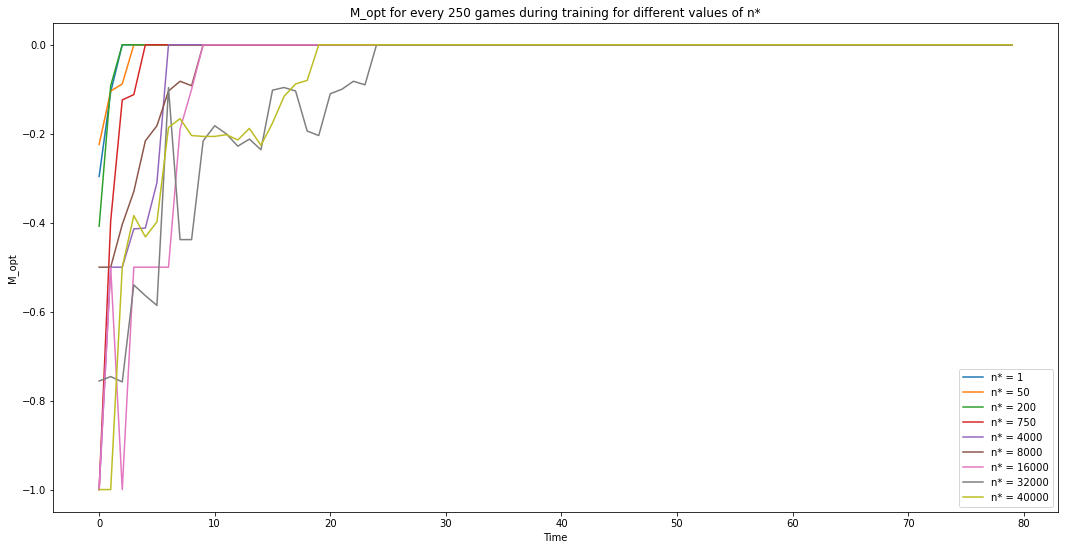

In [8]:
M_opts = result[:,1,:]
M_rands = result[:,2,:]

fig = plt.figure(figsize=(18,9))
for i in range(len(n_stars)):
    y = M_opts[i]
    plt.plot(range(len(y)), y, label = 'n* = ' + str(n_stars[i]))
plt.legend()
plt.title('M_opt for every 250 games during training for different values of n*')
plt.ylabel('M_opt')
plt.xlabel('Time')
plt.show()

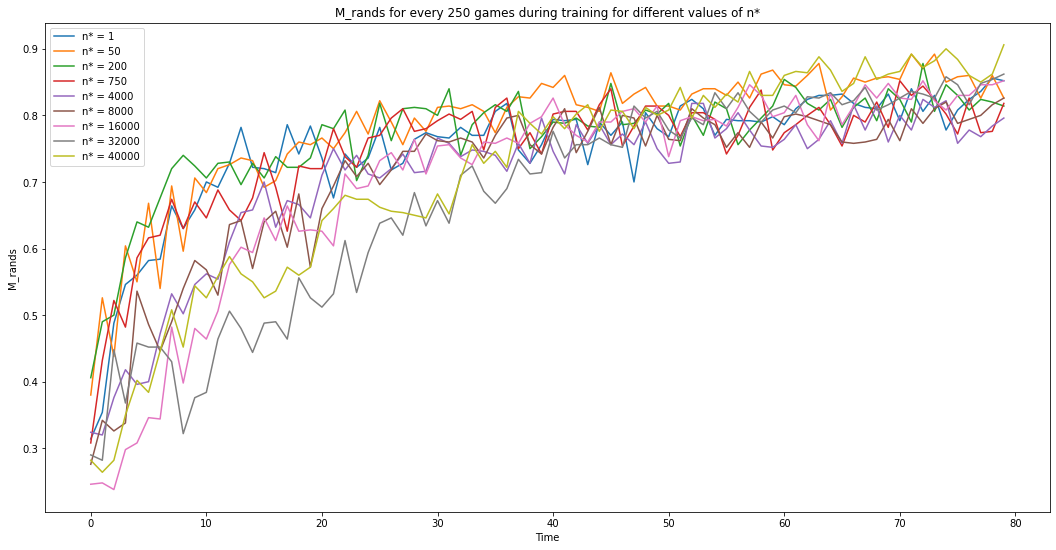

In [9]:
fig = plt.figure(figsize=(18,9))
for i in range(len(n_stars)):
    y = M_rands[i]
    plt.plot(range(len(y)), y, label = 'n* = ' + str(n_stars[i]))
plt.legend()
plt.title('M_rands for every 250 games during training for different values of n*')
plt.ylabel('M_rands')
plt.xlabel('Time')
plt.show()

In [12]:
for i, x in enumerate(M_opts):
    print(f'{n_stars[i]} : {x[-1]}')

1 : 0.0
50 : 0.0
200 : 0.0
750 : 0.0
4000 : 0.0
8000 : 0.0
16000 : 0.0
32000 : 0.0
40000 : 0.0


In [13]:
for i, x in enumerate(M_rands):
    print(f'{n_stars[i]} : {x[-1]}')

1 : 0.852
50 : 0.826
200 : 0.814
750 : 0.818
4000 : 0.796
8000 : 0.826
16000 : 0.852
32000 : 0.862
40000 : 0.906
